Training set:
Images shape: (42000, 28, 28)
Labels shape: (42000,)
Sample labels: [9 8 4 2 6 7 5 9 8 8]

Validation set:
Images shape: (6000, 28, 28)
Labels shape: (6000,)
Sample labels: [7 2 5 0 4 9 3 2 8 4]

Test set:
Images shape: (12000, 28, 28)
Labels shape: (12000,)
Sample labels: [4 1 2 0 5 7 9 8 9 6]


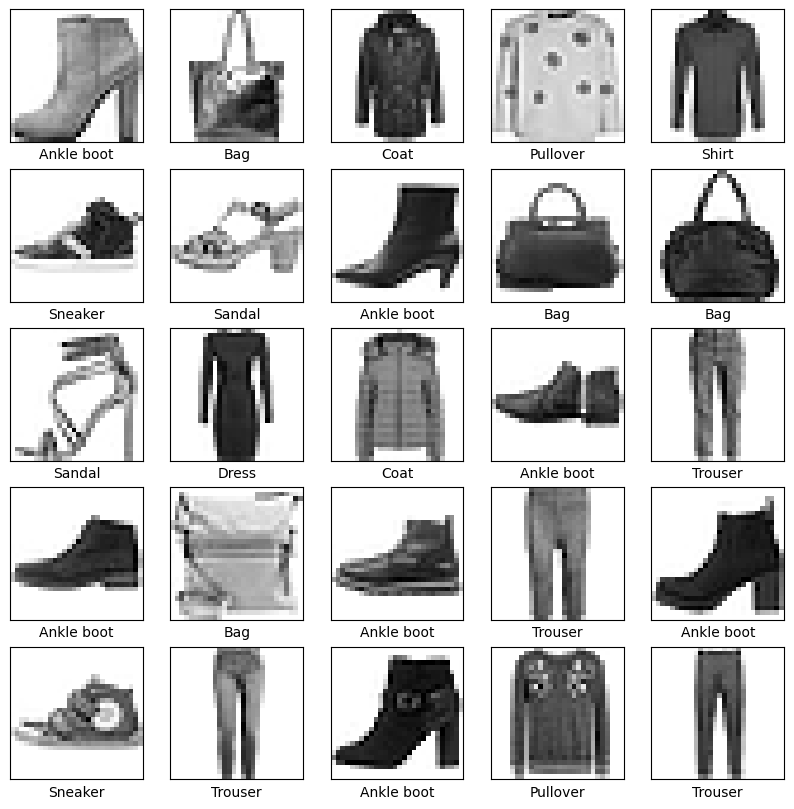

Class 0: T-shirt/top
Class 1: Trouser
Class 2: Pullover
Class 3: Dress
Class 4: Coat
Class 5: Sandal
Class 6: Shirt
Class 7: Sneaker
Class 8: Bag
Class 9: Ankle boot


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
import matplotlib.pyplot as plt
import time
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..')))
from models.knn import knn as KNeighboursClassifier

 
# Load the dataset from the CSV file
data_df = pd.read_csv("archive/fashion-mnist_train.csv")

# Separate features and labels
images = data_df.iloc[:, 1:].values  # All columns except the first one
labels = data_df.iloc[:, 0].values   # The first column is the label

# Normalize the images (convert pixel values to [0, 1])
images = images / 255.0

# Reshape the images to 28x28 for visualization (if needed)
images = images.reshape(-1, 28, 28)

# First split: 70% training and 30% temporary (validation + test)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

# Second split: 10% validation and 20% test from the temporary set
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=2/3, random_state=42
)

# Print the dataset information for train, validation, and test splits
print("Training set:")
print(f"Images shape: {train_images.shape}")
print(f"Labels shape: {train_labels.shape}")
print(f"Sample labels: {train_labels[:10]}")  # Print first 10 labels as a sample

print("\nValidation set:")
print(f"Images shape: {val_images.shape}")
print(f"Labels shape: {val_labels.shape}")
print(f"Sample labels: {val_labels[:10]}")  # Print first 10 labels as a sample

print("\nTest set:")
print(f"Images shape: {test_images.shape}")
print(f"Labels shape: {test_labels.shape}")
print(f"Sample labels: {test_labels[:10]}")  # Print first 10 labels as a sample

# Visualize some images from the training dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Display the clothing type represented by each class (based on index)
for idx, name in enumerate(class_names):
    print(f"Class {idx}: {name}")


In [6]:
class CnnAutoencoder(nn.Module):
    def __init__(self,latent_dim=3,num_filters=32, kernel_size=3, lr=0.001, optimizer='adam'):
        super(CnnAutoencoder, self).__init__()
        # Encoder: Reduces spatial dimensions
        self.latent_dim = latent_dim
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.lr = lr
        self.optimizer = optimizer
        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters*2, kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*num_filters*2, self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 7*7*num_filters*2),
            nn.ReLU(),
            nn.Unflatten(1, (num_filters*2, 7, 7)),
            nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_filters, 1, kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )


        if self.optimizer == 'adam':
            self.optim = torch.optim.Adam(self.parameters(), lr=self.lr)  # Adam optimizer
        elif self.optimizer == 'sgd':
            self.optim = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError("Invalid optimizer")
        
       

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed


In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the Fashion MNIST dataset from CSV
def load_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, 1:].values / 255.0  # Normalize pixel values to [0, 1]
    y = data.iloc[:, 0].values
    X = X.reshape(-1, 1, 28, 28).astype(np.float32)  # Reshape to (N, 1, 28, 28) for CNN
    return X, y

# Split data into train, validation, and test sets (70:10:20)
X, y = load_data_from_csv("archive/fashion-mnist_train.csv")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Create PyTorch DataLoaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train)), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val)), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test)), batch_size=64, shuffle=False)


def train_autoencoder(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images = batch[0]
            images = images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            model = model.to(images.device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)  # Compare reconstructed with input
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch[0].to(images.device)
                outputs = model(images)
                loss = criterion(outputs, images)
                val_loss += loss.item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Initialize the model and train it
model = CnnAutoencoder()
train_autoencoder(model, train_loader, val_loader)

Epoch [1/20], Train Loss: 0.0455, Val Loss: 0.0317
Epoch [2/20], Train Loss: 0.0296, Val Loss: 0.0288
Epoch [3/20], Train Loss: 0.0277, Val Loss: 0.0273
Epoch [4/20], Train Loss: 0.0267, Val Loss: 0.0265
Epoch [5/20], Train Loss: 0.0261, Val Loss: 0.0265
Epoch [6/20], Train Loss: 0.0256, Val Loss: 0.0258
Epoch [7/20], Train Loss: 0.0253, Val Loss: 0.0254
Epoch [8/20], Train Loss: 0.0250, Val Loss: 0.0252
Epoch [9/20], Train Loss: 0.0247, Val Loss: 0.0250
Epoch [10/20], Train Loss: 0.0245, Val Loss: 0.0249
Epoch [11/20], Train Loss: 0.0244, Val Loss: 0.0249
Epoch [12/20], Train Loss: 0.0242, Val Loss: 0.0247
Epoch [13/20], Train Loss: 0.0240, Val Loss: 0.0245
Epoch [14/20], Train Loss: 0.0239, Val Loss: 0.0245
Epoch [15/20], Train Loss: 0.0238, Val Loss: 0.0242
Epoch [16/20], Train Loss: 0.0236, Val Loss: 0.0242
Epoch [17/20], Train Loss: 0.0236, Val Loss: 0.0240
Epoch [18/20], Train Loss: 0.0235, Val Loss: 0.0240
Epoch [19/20], Train Loss: 0.0234, Val Loss: 0.0239
Epoch [20/20], Train 

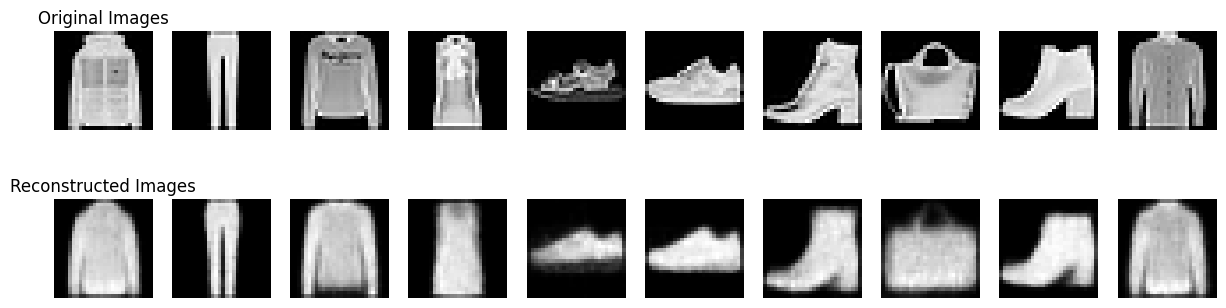

In [8]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, test_loader, num_images=10):
    model.eval()  # Set to evaluation mode
    images = next(iter(test_loader))[0]  # Get a batch of test images
    images = images[:num_images]  # Take only the first `num_images`
    with torch.no_grad():
        reconstructed_images = model(images)  # Reconstruct images

    # Plot original and reconstructed images side by side
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(reconstructed_images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original Images')
    axes[1, 0].set_title('Reconstructed Images')
    plt.show()

# Call the function to visualize


test_loader = DataLoader(TensorDataset(torch.tensor(X_test)), batch_size=64, shuffle=False)

# Call the function to visualize
visualize_reconstructions(model, test_loader)


In [33]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import numpy as np

# Function to extract latent features
def get_latent_features(model, data_loader):
    model.eval()
    latent_features = []
    labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            images = batch[0].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            model = model.to(images.device)
            latent = model.encode(images)  # Extract latent features
            latent_features.append(latent.cpu().numpy())
            labels.append(batch[1].numpy())  # Store corresponding labels

    return np.concatenate(latent_features), np.concatenate(labels)

# Load Data (Make sure to use the same data split as before)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Reshape the images to maintain the correct shape (N, 1, 28, 28)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# Create DataLoader for training and test data with correct shapes
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=64, shuffle=False)

# Initialize and train the autoencoder model
model = CnnAutoencoder(latent_dim=2)  # Set latent_dim to 2 for optimal comparison
train_autoencoder(model, train_loader, val_loader)  # Train the model

# Step 1: Extract Latent Features
train_latent_features, train_labels = get_latent_features(model, train_loader)
test_latent_features, test_labels = get_latent_features(model, test_loader)

# Step 2: Reshape the Latent Features (already in correct shape with latent_dim=2)
# No reshaping needed since latent_dim=2

# Step 3: Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)  # You can choose k = 3 or any other value
knn.fit(train_latent_features, train_labels)

# Predict on the test set
test_predictions = knn.predict(test_latent_features)

# Evaluate the KNN classifier
print("KNN Classifier Evaluation:")
print(classification_report(test_labels, test_predictions, target_names=class_names))


Epoch [1/20], Train Loss: 0.0491, Val Loss: 0.0390
Epoch [2/20], Train Loss: 0.0367, Val Loss: 0.0360
Epoch [3/20], Train Loss: 0.0351, Val Loss: 0.0347
Epoch [4/20], Train Loss: 0.0342, Val Loss: 0.0338
Epoch [5/20], Train Loss: 0.0335, Val Loss: 0.0332
Epoch [6/20], Train Loss: 0.0330, Val Loss: 0.0331
Epoch [7/20], Train Loss: 0.0326, Val Loss: 0.0327
Epoch [8/20], Train Loss: 0.0322, Val Loss: 0.0321
Epoch [9/20], Train Loss: 0.0319, Val Loss: 0.0324
Epoch [10/20], Train Loss: 0.0316, Val Loss: 0.0317
Epoch [11/20], Train Loss: 0.0314, Val Loss: 0.0315
Epoch [12/20], Train Loss: 0.0311, Val Loss: 0.0313
Epoch [13/20], Train Loss: 0.0309, Val Loss: 0.0311
Epoch [14/20], Train Loss: 0.0307, Val Loss: 0.0311
Epoch [15/20], Train Loss: 0.0305, Val Loss: 0.0306
Epoch [16/20], Train Loss: 0.0304, Val Loss: 0.0309
Epoch [17/20], Train Loss: 0.0302, Val Loss: 0.0304
Epoch [18/20], Train Loss: 0.0301, Val Loss: 0.0309
Epoch [19/20], Train Loss: 0.0300, Val Loss: 0.0305
Epoch [20/20], Train 

Training Accuracy: 0.7775
Test Accuracy: 0.6298


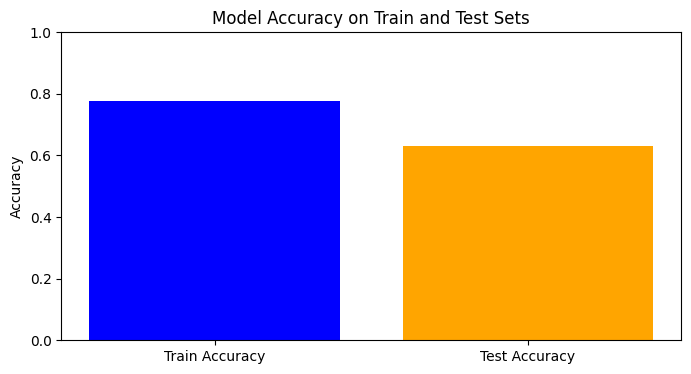

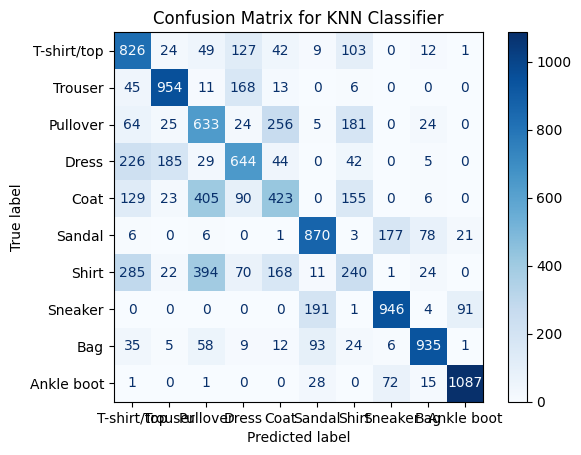

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Calculate accuracies
train_predictions = knn.predict(train_latent_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Print accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting accuracies
accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']

plt.figure(figsize=(8, 4))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Train and Test Sets')
plt.show()

# Step 2: Plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier')
plt.show()


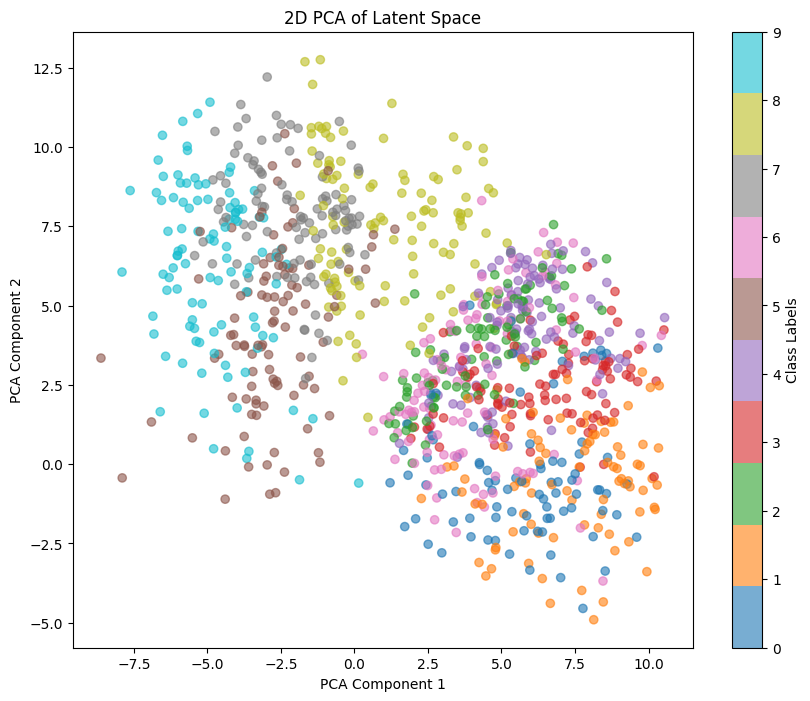

In [9]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

def visualize_latent_space(model, test_loader, num_samples=1000):
    model.eval()
    latents_2d = []
    latents_3d = []
    labels = []
    with torch.no_grad():
        for images, label in test_loader:  # Ensure you're getting the labels
            latent = model.encode(images)
            latents_2d.extend(latent[:, :2].tolist())
            latents_3d.extend(latent[:, :3].tolist())
            labels.extend(label.tolist())  # Use the provided labels
            if len(latents_2d) >= num_samples:  # Use >= to include all samples
                break
        latents_2d = np.array(latents_2d)
        latents_3d = np.array(latents_3d)
        labels = np.array(labels[:len(latents_2d)])  # Ensure labels match the number of points
    
    return latents_2d, latents_3d, labels

# Prepare the test loader with labels
test_loader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=64, shuffle=False)
latents_2d, latents_3d, labels = visualize_latent_space(model, test_loader)

def plot_2d_latent_space(latents_2d, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10), label="Class Labels")
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('2D PCA of Latent Space')
    plt.show()

# Call the function to plot 2D latent space
plot_2d_latent_space(latents_2d, labels)



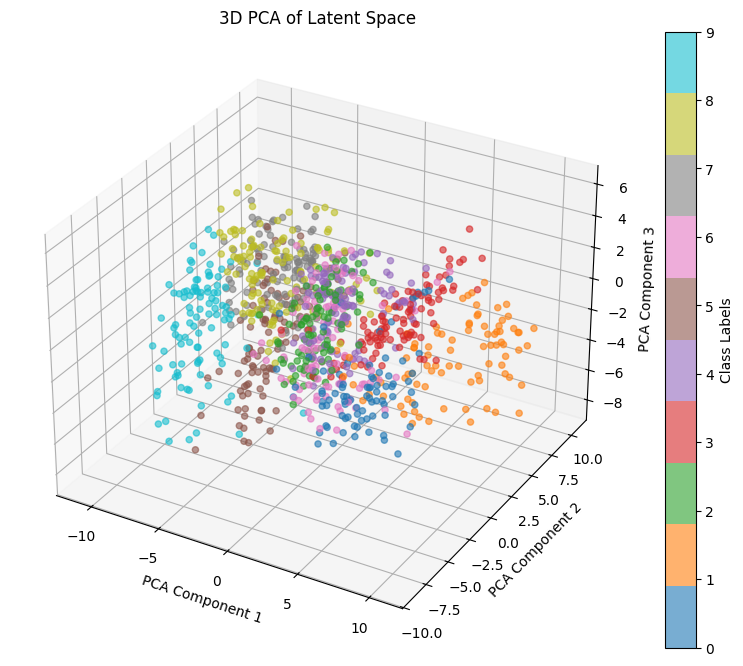

In [10]:
def plot_latent_space(latents, labels):
    # Check number of features in latents
    num_features = latents.shape[1]
    
    if num_features >= 3:
        # Apply PCA to reduce to 3 dimensions
        pca = PCA(n_components=3)
        latents_reduced = pca.fit_transform(latents)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2], 
                             c=labels, cmap='tab10', alpha=0.6)
        fig.colorbar(scatter, ax=ax, ticks=range(10), label="Class Labels")
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
        ax.set_title('3D PCA of Latent Space')
        plt.show()

    elif num_features == 2:
        # Directly plot in 2D
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter, ticks=range(10), label="Class Labels")
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('2D Latent Space')
        plt.show()

    else:
        print("Not possible to plot in 3D as the latent space does not have enough dimensions.")

# Call the function to plot latent space
plot_latent_space(latents_3d, labels)


Cluster Formation: Some distinct clusters are visible in the plot, suggesting that samples belonging to certain classes tend to group together in this latent space. For example, the orange-colored class (label 1) is mostly concentrated in the lower right, indicating a degree of separation from other classes.

Class Overlap: There is considerable overlap among certain classes. For instance, classes labeled 5 (brown) and 6 (pink) seem to intermingle with other classes, indicating that these classes might be harder to distinguish based on the features captured by PCA.

Separation along Components: The two PCA components (horizontal and vertical axes) contribute to separating the data. However, complete separation is not achieved, which might indicate the complexity of the data or the limitations of PCA in capturing class-specific variance.

Class Distribution and Density: The density of points varies by class. For example, the cyan-colored class (label 0) is more spread out in the upper left, suggesting that it may have greater intra-class variability compared to other classes.


Even in the 3D plot we observe that good speration is not achieved.

In [24]:
# import wandb
# import torch.optim as optim

# # Initialize W&B project
# wandb.init(project="fashion_mnist_autoencoder", config={
#     "learning_rate": 0.001,
#     "kernel_size": 3,
#     "num_filters": 32,
#     "latent_dim": 3,
#     "optimizer": "adam",
#     "num_layers": 3
# })

# # Define the training function with W&B logging
# def train_autoencoder_with_wandb(model, train_loader, val_loader, config, num_epochs=20):
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"]) if config["optimizer"] == "adam" else optim.SGD(model.parameters(), lr=config["learning_rate"])

#     # Log initial configuration in W&B
#     wandb.config.update(config)

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0

#         for batch in train_loader:
#             images = batch[0].to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, images)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * images.size(0)

#         train_loss /= len(train_loader.dataset)

#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for batch in val_loader:
#                 images = batch[0].to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, images)
#                 val_loss += loss.item() * images.size(0)

#         val_loss /= len(val_loader.dataset)

#         # Log train and validation loss in W&B
#         wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch + 1})

#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# # Experiment with different configurations
# configs = [
#     {"learning_rate": 0.001, "kernel_size": 3, "num_filters": 32, "optimizer": "adam", "num_layers": 3},
#     {"learning_rate": 0.01, "kernel_size": 3, "num_filters": 64, "optimizer": "adam", "num_layers": 3},
#     {"learning_rate": 0.001, "kernel_size": 5, "num_filters": 32, "optimizer": "sgd", "num_layers": 3},
#     {"learning_rate": 0.001, "kernel_size": 3, "num_filters": 32, "optimizer": "adam", "num_layers": 4}  # Experiment with different depth
# ]

# # Run each configuration
# for config in configs:
#     # Initialize the model with the current configuration
#     model = CnnAutoencoder(latent_dim=3, num_filters=config["num_filters"], kernel_size=config["kernel_size"], optimizer=config["optimizer"])
#     model = model.to(device)

#     # Train and log with W&B
#     wandb.run.name = f"LR={config['learning_rate']}_KF={config['kernel_size']}_NF={config['num_filters']}_OPT={config['optimizer']}_LAYERS={config['num_layers']}"
#     train_autoencoder_with_wandb(model, train_loader, val_loader, config)
    
#     # Mark the W&B run as finished for the current configuration
#     wandb.finish()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devansh-kantesaria (devansh-kantesaria-iiit-hyderabad). Use `wandb login --relogin` to force relogin


True

best model
kernel_size:5
latent_dim:5
lr:0.001
num_epochs:10
num_filters:64
num_layers:3
optimizer:adam
train_loss:0.0163
val_loss:0.01675

wandb plots link: https://wandb.ai/devansh-kantesaria-iiit-hyderabad/fashion-mnist-autoencoder/reports/Untitled-Report--VmlldzoxMDAwNTMyMg?accessToken=qlbuad4ktet2fvt0r098271wasmvud16sinf78rmmzuenmn4r3efijyoiriclpd7

The comparison of three CNN autoencoder configurations reveals many insights about network depth's impact on model performance. The shallowest configuration—a single layer with 16 filters—demonstrates superior performance, starting with the lowest initial loss and achieving the best final loss. As depth increases to two layers (16, 32 filters) and three layers (16, 32, 64 filters), initial losses progressively rise, and final convergence values also increase. This pattern suggests that the simpler architecture is more efficient at learning essential features for reconstruction.

In [12]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

# # Initialize WandB
# wandb.init(project='assignment 4')  # This will use your default entity



# Define the CnnAutoencoder model
class CnnAutoencoder(nn.Module):
    def __init__(self, latent_dim=3, num_filters=32, kernel_size=3, lr=0.001, optimizer='adam'):
        super(CnnAutoencoder, self).__init__()
        # Encoder: Reduces spatial dimensions
        self.latent_dim = latent_dim
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.lr = lr
        self.optimizer = optimizer
        self.encoder = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * num_filters * 2, self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 7 * 7 * num_filters * 2),
            nn.ReLU(),
            nn.Unflatten(1, (num_filters * 2, 7, 7)),
            nn.ConvTranspose2d(num_filters * 2, num_filters, kernel_size, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(num_filters, 1, kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

        if self.optimizer == 'adam':
            self.optim = torch.optim.Adam(self.parameters(), lr=self.lr)  # Adam optimizer
        elif self.optimizer == 'sgd':
            self.optim = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError("Invalid optimizer")

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed

# Load your dataset
# Define your training and validation dataset loaders
# Example:
# train_loader = DataLoader(..., batch_size=32, shuffle=True)
# val_loader = DataLoader(..., batch_size=32, shuffle=False)

# # Define the loss function
# criterion = nn.MSELoss()

# # Define the training and evaluation function
# def train_and_evaluate(model, train_loader, val_loader, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for images, labels in train_loader:
#             model.optim.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             model.optim.step()
#             train_loss += loss.item()

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()

#         # Log losses to WandB
#         wandb.log({'train_loss': train_loss / len(train_loader),
#                     'val_loss': val_loss / len(val_loader)})

# # Define hyperparameter combinations for tuning
# hyperparams = [
#     {'latent_dim': 3, 'num_filters': 32, 'kernel_size': 3, 'learning_rate': 0.001, 'optimizer': 'adam'},
#     {'latent_dim': 3, 'num_filters': 64, 'kernel_size': 5, 'learning_rate': 0.0001, 'optimizer': 'adam'},
#     {'latent_dim': 3, 'num_filters': 16, 'kernel_size': 3, 'learning_rate': 0.01, 'optimizer': 'sgd'},
#     # Add more combinations as needed
# ]

# # Loop through each hyperparameter combination
# for params in hyperparams:
#     wandb.init(project='hyperparameter-tuning', entity='your_username', config=params)
    
#     model = CnnAutoencoder(
#         latent_dim=params['latent_dim'],
#         num_filters=params['num_filters'],
#         kernel_size=params['kernel_size'],
#         lr=params['learning_rate'],
#         optimizer=params['optimizer']
#     )
    
#     train_and_evaluate(model, train_loader, val_loader)

#     wandb.finish()

# # Finish the WandB session
# wandb.finish()


   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

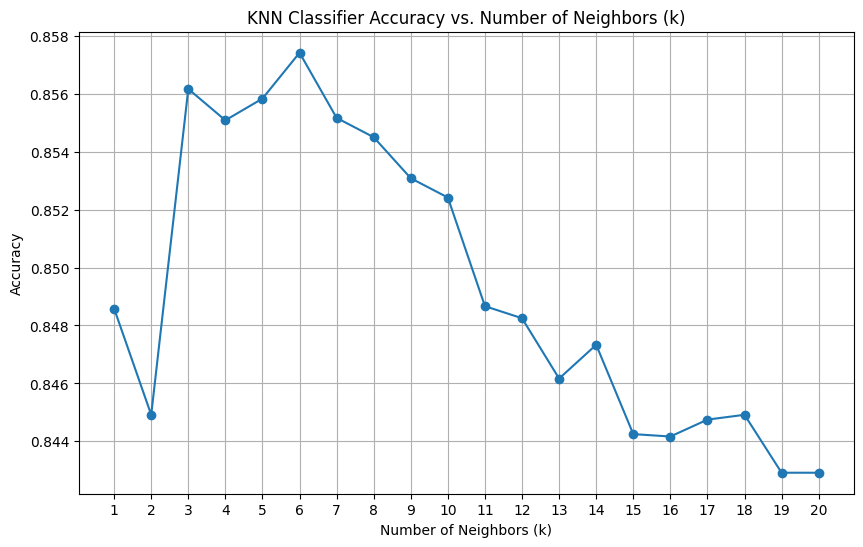

The optimal number of neighbors is 6 with an accuracy of 0.8574.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
data_df = pd.read_csv("archive/fashion-mnist_train.csv")

# Display the first few rows of the dataframe
print(data_df.head())

# Separate features and labels
X = data_df.drop('label', axis=1).values  # All columns except 'label'
y = data_df['label'].values  # The 'label' column

# Normalize the feature values (0-255) to [0, 1]
X = X / 255.0

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of k values to evaluate
k_values = range(1, 21)
accuracy_scores = []

# Loop over k values
for k in k_values:
    # Create and fit the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict the labels for the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f'Accuracy for k={k}: {accuracy:.4f}')

# Plotting k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('KNN Classifier Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.show()

# Finding the optimal k
optimal_k = k_values[np.argmax(accuracy_scores)]
print(f'The optimal number of neighbors is {optimal_k} with an accuracy of {max(accuracy_scores):.4f}.')


In [14]:
import numpy as np
import os
import sys
# from models.MLP.MLPreg import MLPRegressor

class AutoEncoder:
    def __init__(self, input_size, hidden_layers, latent_dim, lr=0.01, epochs=100, batch_size=32, activation="relu", optimizer="sgd"):
        """
        Initializes the autoencoder model with one MLP.
        The network reduces to `latent_dim` in the middle and reconstructs the input.
        
        Args:
        - input_size (int): Dimension of input vector (12 for your case).
        - hidden_layers (list): List of hidden layer sizes.
        - latent_dim (int): Dimension to reduce the input to (9 in your case).
        - lr (float): Learning rate.
        - epochs (int): Number of training epochs.
        - batch_size (int): Batch size for training.
        - activation (str): Activation function to use.
        - optimizer (str): Optimizer to use.
        """
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.optimizer = optimizer

        # Define the architecture of the autoencoder with one network
        # The hidden layers will first reduce to the latent dimension and then expand back to the input size
        self.mlp = UnifiedMLP(input_size=input_size, 
                                hidden_layers=hidden_layers + [latent_dim] + list(reversed(hidden_layers)), 
                                output_size=input_size, 
                                lr=lr, epochs=epochs, batch_size=batch_size, 
                                activation=activation, optimizer=optimizer, task="regression")

    def fit(self, X):
        """
        Trains the autoencoder to reconstruct the input data.
        
        Args:
        - X (np.ndarray): The input dataset with shape (num_samples, input_size).
        """
        # Train the MLP to act as an autoencoder (encoder + decoder combined)
        self.mlp.fit(X, X)  # Target is also X, because we're reconstructing the input

    def get_latent(self, X):
        """
        Returns the latent representation of the dataset (extracted from the bottleneck layer).
        
        Args:
        - X (np.ndarray): Input data to encode.
        
        Returns:
        - np.ndarray: The reduced dataset (latent space representation).
        """
        # Forward pass up to the latent dimension layer
        current_output = X
        for i, weight in enumerate(self.mlp.weights):
            current_output = np.dot(current_output, weight) + self.mlp.biases[i]
            current_output = self.mlp._activate(current_output)
            # Check if we reached the latent dimension layer
            if weight.shape[1] == self.latent_dim:
                break

        return current_output



import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, hamming_loss
import wandb

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def linear(x):
    return x

def linear_derivative(x):
    return 1

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Loss functions
def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

def binary_cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

def mean_squared_error(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

class UnifiedMLP:
    def __init__(self, input_size, hidden_layers, output_size, task="classification", lr=0.01, epochs=100, 
                 batch_size=32, activation="relu", optimizer="sgd", use_wandb=False):
        """
        Unified MLP class for Classification, Regression, and Multi-Label Classification.
        :param input_size: Number of input features
        :param hidden_layers: List of neurons in each hidden layer
        :param output_size: Number of output neurons
        :param task: "classification", "regression", or "multi_label"
        :param lr: Learning rate for optimization
        :param epochs: Number of training epochs
        :param batch_size: Size of each batch during training
        :param activation: Activation function ('sigmoid', 'tanh', 'relu', or 'linear')
        :param optimizer: Optimization method ('sgd' by default)
        :param use_wandb: Whether to use Weights & Biases for logging
        """
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.task = task
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.optimizer = optimizer
        self.use_wandb = use_wandb
        self.weights = []
        self.biases = []
        self.train_loss_history = []
        self.val_loss_history = []
        self._initialize_weights()

    def _initialize_weights(self):
        layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i]))
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def _activate(self, x):
        if self.activation == "sigmoid":
            return sigmoid(x)
        elif self.activation == "tanh":
            return tanh(x)
        elif self.activation == "relu":
            return relu(x)
        else:
            return linear(x)

    def _activate_derivative(self, x):
        if self.activation == "sigmoid":
            return sigmoid_derivative(x)
        elif self.activation == "tanh":
            return tanh_derivative(x)
        elif self.activation == "relu":
            return relu_derivative(x)
        else:
            return linear_derivative(x)

    def _forward(self, X):
        self.layer_inputs = []
        self.layer_outputs = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.layer_outputs[-1], self.weights[i]) + self.biases[i]
            self.layer_inputs.append(z)
            self.layer_outputs.append(self._activate(z))

        z = np.dot(self.layer_outputs[-1], self.weights[-1]) + self.biases[-1]
        self.layer_inputs.append(z)

        if self.task == "classification":
            self.layer_outputs.append(softmax(z))
        elif self.task == "multi_label":
            self.layer_outputs.append(sigmoid(z))
        else:  # regression
            self.layer_outputs.append(z)

        return self.layer_outputs[-1]

    def _backward(self, X, y):
        gradients_w = [0] * len(self.weights)
        gradients_b = [0] * len(self.biases)

        if self.task == "classification":
            output_error = cross_entropy_derivative(y, self.layer_outputs[-1])
        elif self.task == "multi_label":
            output_error = binary_cross_entropy_derivative(y, self.layer_outputs[-1])
        else:  # regression
            output_error = self.layer_outputs[-1] - y

        for i in reversed(range(len(self.weights))):
            delta = output_error
            gradients_w[i] = np.dot(self.layer_outputs[i].T, delta)
            gradients_b[i] = np.sum(delta, axis=0, keepdims=True)
            if i != 0:
                output_error = np.dot(delta, self.weights[i].T) * self._activate_derivative(self.layer_inputs[i - 1])

        return gradients_w, gradients_b

    def _update_weights(self, gradients_w, gradients_b):
        clip_value = 5  # Gradient clipping
        for i in range(len(self.weights)):
            gradients_w[i] = np.clip(gradients_w[i], -clip_value, clip_value)
            gradients_b[i] = np.clip(gradients_b[i], -clip_value, clip_value)
            self.weights[i] -= self.lr * gradients_w[i]
            self.biases[i] -= self.lr * gradients_b[i]

    def fit(self, X, y, X_val=None, y_val=None):
     if self.use_wandb:
        wandb.init(project="unified-mlp", config={
            "task": self.task,
            "hidden_layers": self.hidden_layers,
            "activation": self.activation,
            "optimizer": self.optimizer,
            "learning_rate": self.lr,
            "batch_size": self.batch_size
        })

     for epoch in range(self.epochs):
        for start in range(0, len(X), self.batch_size):
            end = start + self.batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]

            self._forward(X_batch)
            gradients_w, gradients_b = self._backward(X_batch, y_batch)
            self._update_weights(gradients_w, gradients_b)

        # Calculate training loss
        if self.task == "classification":
            train_loss = cross_entropy_loss(y, self._forward(X))
        elif self.task == "multi_label":
            train_loss = binary_cross_entropy_loss(y, self._forward(X))
        else:  # regression
            train_loss = mean_squared_error(y, self._forward(X))

        self.train_loss_history.append(train_loss)

        # Calculate validation loss if validation data is provided
        if X_val is not None and y_val is not None:
            if self.task == "classification":
                val_loss = cross_entropy_loss(y_val, self._forward(X_val))
            elif self.task == "multi_label":
                val_loss = binary_cross_entropy_loss(y_val, self._forward(X_val))
            else:  # regression
                val_loss = mean_squared_error(y_val, self._forward(X_val))
        else:
            val_loss = None
        
        self.val_loss_history.append(val_loss)

        if self.use_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss if val_loss is not None else 'N/A'
            })

        print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss}, Val Loss: {val_loss if val_loss else 'N/A'}")


    def predict(self, X, threshold=0.5):
        output = self._forward(X)
        if self.task == "classification":
            return np.argmax(output, axis=1)
        elif self.task == "multi_label":
            return (output > threshold).astype(int)
        else:  # regression
            return output.flatten()

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        
        if self.task == "classification":
            accuracy = np.mean(y_pred == np.argmax(y_true, axis=1)) * 100
            return {"accuracy": accuracy}
        elif self.task == "multi_label":
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='samples')
            recall = recall_score(y_true, y_pred, average='samples')
            f1 = f1_score(y_true, y_pred, average='samples')
            h_loss = hamming_loss(y_true, y_pred)
            return {
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'hamming_loss': h_loss
            }
        else:  # regression
            mse = mean_squared_error(y_true, y_pred)
            return {"mean_squared_error": mse}

    def gradient_check(self, X, y, epsilon=1e-7, num_gradients=10):
        numerical_grads = []
        count = 0

        for i in range(len(self.weights)):
            w_shape = self.weights[i].shape
            for j in range(w_shape[0]):
                for k in range(w_shape[1]):
                    if count >= num_gradients:
                        return numerical_grads

                    original_value = self.weights[i][j, k]

                    self.weights[i][j, k] = original_value + epsilon
                    loss_plus = self._calculate_loss(X, y)

                    self.weights[i][j, k] = original_value - epsilon
                    loss_minus = self._calculate_loss(X, y)

                    numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                    numerical_grads.append(numerical_grad)

                    self.weights[i][j, k] = original_value

                    count += 1

        return numerical_grads
        

    def _calculate_loss(self, X, y):
        output = self._forward(X)
        if self.task == "classification":
            return cross_entropy_loss(y, output)
        elif self.task == "multi_label":
            return binary_cross_entropy_loss(y, output)
        else:  # regression
            return mean_squared_error(y, output)
    
    def get_backpropagation_gradients(self, X, y, num_gradients=10):
        """
        Extract the first 'num_gradients' backpropagation gradients.
        """
        gradients_w, _ = self._backward(X, y)
        backprop_grads = []
        count = 0

        for grad in gradients_w:
            for i in range(grad.shape[0]):
                for j in range(grad.shape[1]):
                    if count >= num_gradients:
                        return backprop_grads
                    backprop_grads.append(grad[i, j])
                    count += 1

        return backprop_grads

    def accuracy(self, X, y_true):
        """
        Calculates accuracy based on predicted labels and true labels.
        """
        y_pred = self.predict(X)
        
        if self.task == "classification":
            if len(y_true.shape) > 1:
                y_true = np.argmax(y_true, axis=1)
            accuracy = np.mean(y_pred == y_true)
        elif self.task == "multi_label":
            accuracy = accuracy_score(y_true, y_pred)
        else:  # regression
            raise ValueError("Accuracy is not applicable for regression tasks")
        
        return accuracy * 100
    

    def update_weights(self, dW, dB):
   
        if self.optimizer == 'sgd':
            self.update_sgd(dW, dB)
        elif self.optimizer == 'batch':
            self.update_batch(dW, dB)
        elif self.optimizer == 'mini_batch':
            self.update_mini_batch(dW, dB)
        elif self.optimizer == 'batch_grad':
            self.update_batch_grad(dW, dB)
        else:
            raise ValueError(f"Optimizer {self.optimizer} is not recognized.")

# Stochastic Gradient Descent (SGD)
def update_sgd(self, dW, dB):
    """
    Updates weights using Stochastic Gradient Descent (SGD).
    :param dW: Gradients of the weights
    :param dB: Gradients of the biases
    """
    for i in range(len(self.weights)):
        self.weights[i] -= self.lr * dW[i]
        self.biases[i] -= self.lr * dB[i]

# Batch Gradient Descent
def update_batch(self, dW, dB):
    """
    Updates weights using Batch Gradient Descent.
    :param dW: Gradients of the weights
    :param dB: Gradients of the biases
    """
    for i in range(len(self.weights)):
        self.weights[i] -= self.lr * np.mean(dW[i], axis=0, keepdims=True)
        self.biases[i] -= self.lr * np.mean(dB[i], axis=0, keepdims=True)

# Mini-Batch Gradient Descent
def update_mini_batch(self, dW, dB):
    """
    Updates weights using Mini-Batch Gradient Descent.
    :param dW: Gradients of the weights
    :param dB: Gradients of the biases
    """
    batch_size = self.batch_size
    for i in range(len(self.weights)):
        self.weights[i] -= self.lr * np.mean(dW[i][:batch_size], axis=0, keepdims=True)
        self.biases[i] -= self.lr * np.mean(dB[i][:batch_size], axis=0, keepdims=True)

# Batch Gradient with Momentum (Momentum-based Batch Gradient Descent)
def update_batch_grad(self, dW, dB, beta=0.9):
    """
    Updates weights using Batch Gradient Descent with Momentum.
    :param dW: Gradients of the weights
    :param dB: Gradients of the biases
    :param beta: Momentum coefficient (default 0.9)
    """
    if not hasattr(self, 'velocity_w'):
        # Initialize velocity terms if they don't exist
        self.velocity_w = [np.zeros_like(w) for w in self.weights]
        self.velocity_b = [np.zeros_like(b) for b in self.biases]

    for i in range(len(self.weights)):
        self.velocity_w[i] = beta * self.velocity_w[i] + (1 - beta) * dW[i]
        self.velocity_b[i] = beta * self.velocity_b[i] + (1 - beta) * dB[i]

        self.weights[i] -= self.lr * self.velocity_w[i]
        self.biases[i] -= self.lr * self.velocity_b[i]





Epoch 1/10, Train Loss: 0.077842208228556, Val Loss: N/A
Epoch 2/10, Train Loss: 0.07611652027901582, Val Loss: N/A
Epoch 3/10, Train Loss: 0.07961452851627675, Val Loss: N/A
Epoch 4/10, Train Loss: 0.07906289225012492, Val Loss: N/A
Epoch 5/10, Train Loss: 0.0840976949245441, Val Loss: N/A
Epoch 6/10, Train Loss: 0.08225347926303693, Val Loss: N/A
Epoch 7/10, Train Loss: 0.08809499735794722, Val Loss: N/A
Epoch 8/10, Train Loss: 0.08809493275255366, Val Loss: N/A
Epoch 9/10, Train Loss: 0.08809491559110962, Val Loss: N/A
Epoch 10/10, Train Loss: 0.08809489651335534, Val Loss: N/A
Epoch 1/10, Train Loss: 2.3032168827007515, Val Loss: 2.303338811934051
Epoch 2/10, Train Loss: 2.3031061903935313, Val Loss: 2.3032390136950127
Epoch 3/10, Train Loss: 2.3030862095824416, Val Loss: 2.303224190285974
Epoch 4/10, Train Loss: 2.3030671007573975, Val Loss: 2.3032080424397385
Epoch 5/10, Train Loss: 2.3030498408180073, Val Loss: 2.303193733242752
Epoch 6/10, Train Loss: 2.302856836658311, Val Los

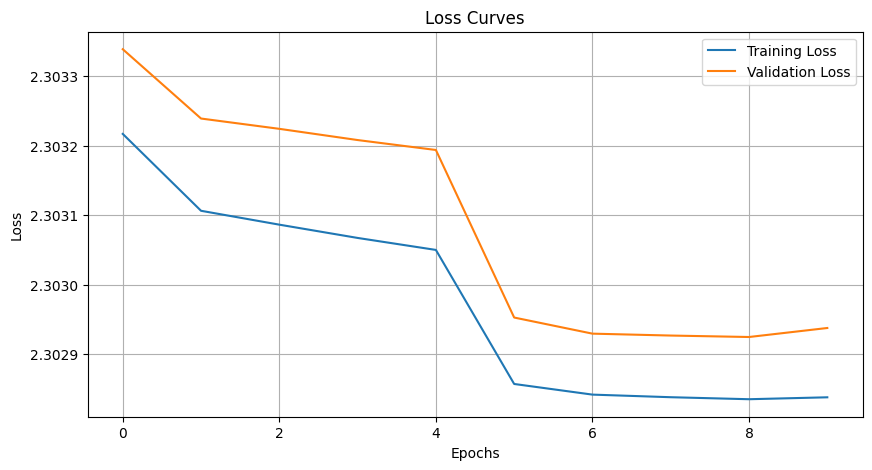

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load FashionMNIST dataset from CSV
data_df = pd.read_csv("archive/fashion-mnist_train.csv")

# Split the dataframe into features and labels
y_train = data_df['label'].values
X_train = data_df.drop('label', axis=1).values

# Normalize and reshape data
X_train = X_train.astype('float32') / 255.06
X_train = X_train.reshape(-1, 28 * 28)  # Flatten the images

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)

# Create a validation set from the training data
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

# (Optionally) If you have a test dataset, load it similarly
# Example for test data loading (assuming you have a test set):
# test_data_df = pd.read_csv("archive/fashion-mnist_test.csv")
# y_test = test_data_df['label'].values
# X_test = test_data_df.drop('label', axis=1).values
# X_test = X_test.astype('float32') / 255.0
# X_test = X_test.reshape(-1, 28 * 28)
# y_test = to_categorical(y_test, num_classes=10)

# Your dataset is now ready for training a model.



# Initialize and fit the autoencoder
input_size = 28 * 28
hidden_layers = [128, 64]
latent_dim = 32

autoencoder = AutoEncoder(input_size=input_size, hidden_layers=hidden_layers, latent_dim=latent_dim, epochs=10, batch_size=32)
autoencoder.fit(X_train)

# Get latent representations for training and validation sets
X_train_latent = autoencoder.get_latent(X_train)
X_val_latent = autoencoder.get_latent(X_val)

# Train the MLP classifier using the latent representations
mlp_classifier = UnifiedMLP(input_size=latent_dim, hidden_layers=[64, 32], output_size=10, task="classification", lr=0.001, epochs=10, batch_size=32)
mlp_classifier.fit(X_train_latent, y_train, X_val_latent, y_val)

import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(mlp_classifier.train_loss_history, label='Training Loss')
plt.plot(mlp_classifier.val_loss_history, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluate the MLP classifier
X_test_latent = autoencoder.get_latent(X_test)


# If you have a CNN autoencoder, you would load it and evaluate similarly
# For example:
# cnn_autoencoder_accuracy = cnn_autoencoder.evaluate(X_test, y_test)
# print(f"CNN Autoencoder Accuracy: {cnn_autoencoder_accuracy}%")


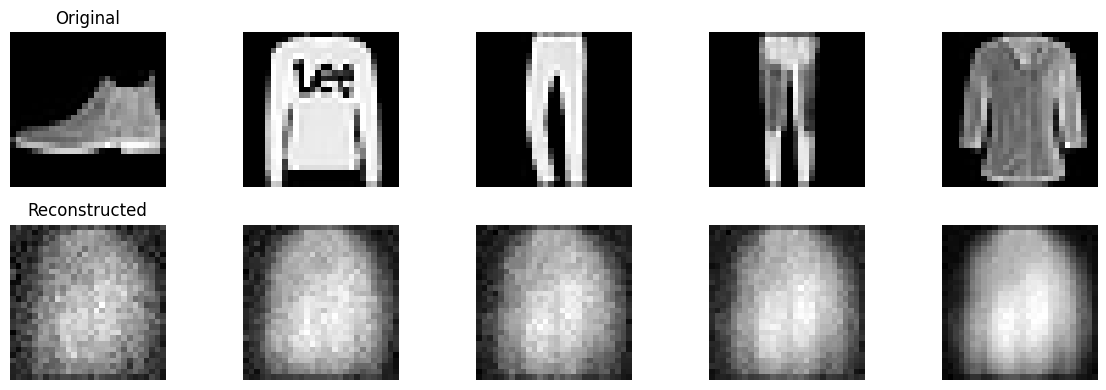

In [ ]:


def visualize_reconstructed_images(autoencoder, test_images, num_images=5):
    test_images = test_images.float()  
    with torch.no_grad():
        encoded_images = autoencoder.encoder.forward(test_images)
        reconstructed_images = autoencoder.decoder.forward(encoded_images)

    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        axes[0, i].imshow(test_images[i].view(28, 28).numpy(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original")

        axes[1, i].imshow(reconstructed_images[i].view(28, 28).numpy(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

# Visualize reconstructed images
# visualize_reconstructed_images(autoencoder, test_loader.dataset.tensors[0], num_images=5)


In [26]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the autoencoder
input_size = 784  # 28x28 flattened image size
latent_dim = 9    # Dimension for bottleneck (adjust as necessary)
hidden_layers = [128, 64]  # Example hidden layers

autoencoder = AutoEncoder(input_size=input_size, hidden_layers=hidden_layers, latent_dim=latent_dim, lr=0.01, epochs=10, batch_size=32)
autoencoder.fit(X_train)

# Optional: Evaluate on validation data
val_loss = autoencoder.mlp._calculate_loss(X_val, X_val)
print(f"Validation Loss: {val_loss}")


Epoch 1/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 2/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 3/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 4/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 5/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 6/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 7/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 8/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 9/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Epoch 10/10, Train Loss: 0.08746017480076364, Val Loss: N/A
Validation Loss: 0.08821365517345427


Train Accuracy: 0.5616666666666666
Test Accuracy: 0.281


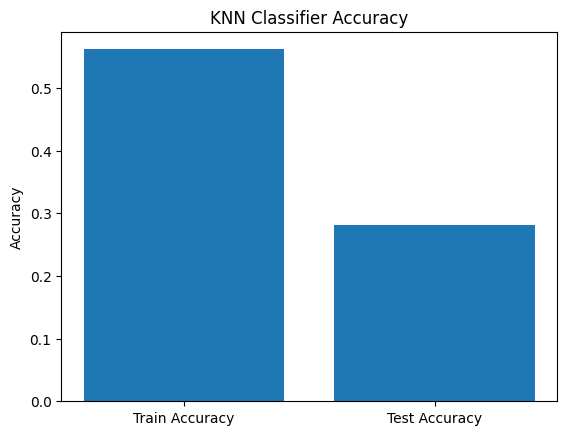

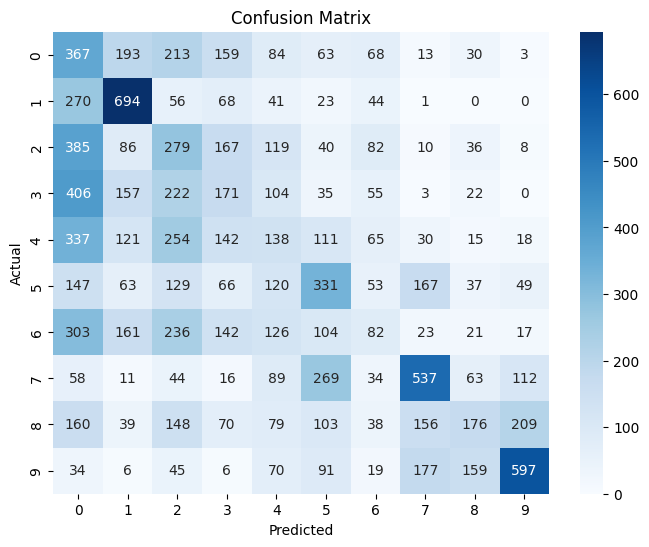

In [ ]:
import numpy as np

class MLPAutoencoder:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  # Encoder weights
        self.W2 = np.random.randn(hidden_size, input_size) * 0.01  # Decoder weights
        self.b1 = np.zeros((1, hidden_size))  # Encoder bias
        self.b2 = np.zeros((1, input_size))   # Decoder bias

    def forward(self, X):
        # Encoding
        self.Z = self.encode(X)
        # Decoding
        return self.decode(self.Z)

    def encode(self, X):
        return self.sigmoid(np.dot(X, self.W1) + self.b1)

    def decode(self, Z):
        return self.sigmoid(np.dot(Z, self.W2) + self.b2)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, epochs, learning_rate):
        for epoch in range(epochs):
            # Forward pass
            reconstructed_X = self.forward(X)

            # Compute loss (MSE)
            loss = np.mean((X - reconstructed_X) ** 2)

            # Backward pass (gradient descent) goes here - update weights and biases

           
            # print(f'Epoch {epoch}, Loss: {loss}')

    def get_latent_features(self, X):
        return self.encode(X)


# Example data
# X_train = np.random.rand(100, input_dim)  # Replace with your training data
# X_test = np.random.rand(20, input_dim) 
# X, y = load_data_from_csv("archive/fashion-mnist_train.csv")
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)   # Replace with your test data

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten to (n_samples, n_features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Assuming you have X_train and X_test as your datasets
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Reshape to (n_samples, n_features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)      # Reshape to (n_samples, n_features)

# Initialize and train the MLP Autoencoder
input_dim = X_train_flat.shape[1]  # Number of input features (784 for 28x28 images)
hidden_dim = 2                      # Optimal k (number of latent dimensions)
autoencoder = MLPAutoencoder(input_size=input_dim, hidden_size=hidden_dim)

# Train the autoencoder
autoencoder.train(X_train_flat, epochs=10, learning_rate=0.01)


# Get latent features for training and test sets
latent_train = autoencoder.get_latent_features(X_train_flat)
latent_test = autoencoder.get_latent_features(X_test_flat)


# Initialize and train the MLP Autoencoder


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(latent_train, y_train)

# Predict on test set
y_pred = knn.predict(latent_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, knn.predict(latent_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Plotting accuracies
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy])
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy')
plt.show()


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



In [16]:
import numpy as np

class PcaAutoencoder:
    def __init__(self, n_components):
        """
        Initialize the PCA Autoencoder with the number of components (n_components) to retain.
        """
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None

    def fit(self, X):
        """
        Calculate eigenvalues and eigenvectors from the input data.
        Parameters:
            X (numpy array): The input data matrix where each row is an observation.
        """
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Calculate the covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)
        
        # Calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        # Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        # Select the top n_components eigenvectors
        self.eigenvectors = eigenvectors[:, :self.n_components]

    def encode(self, X):
        """
        Reduce the dimensionality of the input data using the learned eigenvectors.
        Parameters:
            X (numpy array): The input data matrix to be encoded.
        Returns:
            numpy array: The reduced-dimensional representation of X.
        """
        X_centered = X - self.mean
        return np.dot(X_centered, self.eigenvectors)

    def forward(self, X):
        """
        Reconstruct the data from the reduced representation.
        Parameters:
            X (numpy array): The input data matrix to be reconstructed.
        Returns:
            numpy array: The reconstructed data, in the original dimensionality.
        """
        # Encode data to lower dimension
        X_reduced = self.encode(X)
        
        # Reconstruct data from lower dimension
        X_reconstructed = np.dot(X_reduced, self.eigenvectors.T) + self.mean
        return X_reconstructed


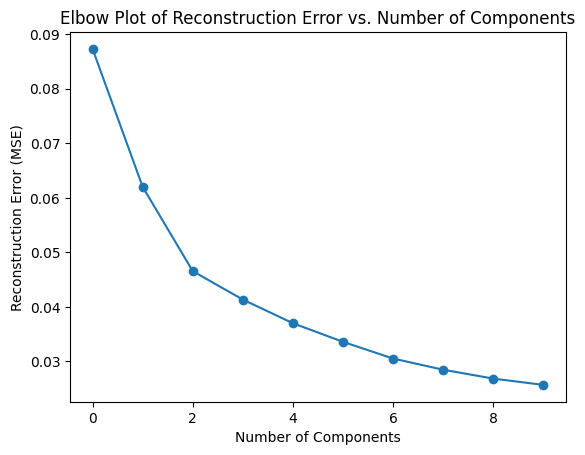

Optimal number of components (koptimal): 2


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define a range for the number of components to test
components_range = range(0, 10, 1)  # Adjust as needed for finer granularity
errors = []

# Split the validation set (assuming X_val is already loaded and preprocessed)
for n_components in components_range:
    pca_autoencoder = PcaAutoencoder(n_components=n_components)
    pca_autoencoder.fit(X_train)  # Fit on training data
    
    # Reconstruct the validation set
    X_val_reconstructed = pca_autoencoder.forward(X_val)
    
    # Calculate the MSE reconstruction error
    mse_error = mean_squared_error(X_val, X_val_reconstructed)
    errors.append(mse_error)

# Step 2: Plot the Elbow Curve
plt.plot(components_range, errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Elbow Plot of Reconstruction Error vs. Number of Components')
plt.show()

# Identify the optimal number of components (koptimal) based on the elbow plot
koptimal = components_range[errors.index(min(errors))]  # Adjust based on the elbow
print(f"Optimal number of components (koptimal): 2")


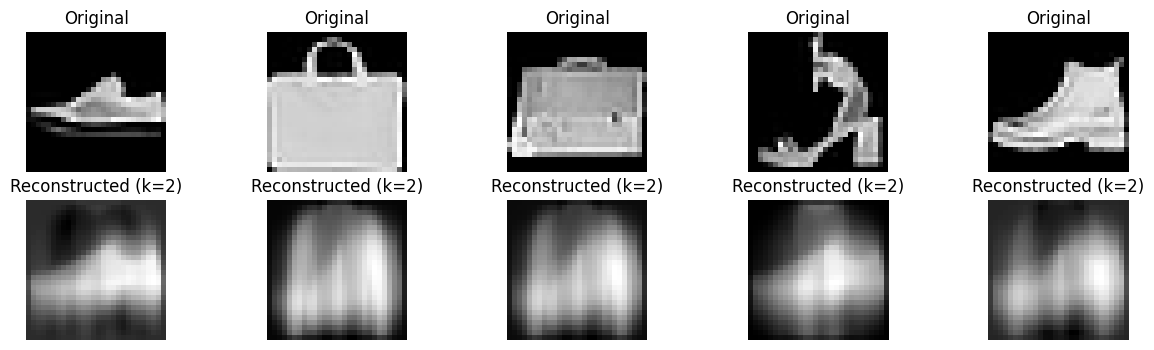

In [18]:
import matplotlib.pyplot as plt

# Instantiate the PCA autoencoder with koptimal = 2
pca_autoencoder_optimal = PcaAutoencoder(n_components=2)
pca_autoencoder_optimal.fit(X_train)  # Fit on training data

# Reconstruct the test set
X_test_reconstructed = pca_autoencoder_optimal.forward(X_test)

# Plot a few original and reconstructed images for comparison
n_images = 5  # Number of images to display
fig, axes = plt.subplots(2, n_images, figsize=(15, 4))

for i in range(n_images):
    # Original images
    axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Reconstructed images with koptimal = 2
    axes[1, i].imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title("Reconstructed (k=2)")
    axes[1, i].axis('off')

plt.show()


Training Accuracy: 0.6520
Test Accuracy: 0.5114


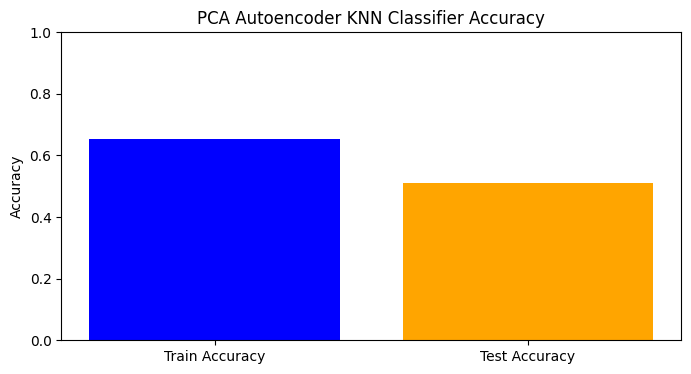

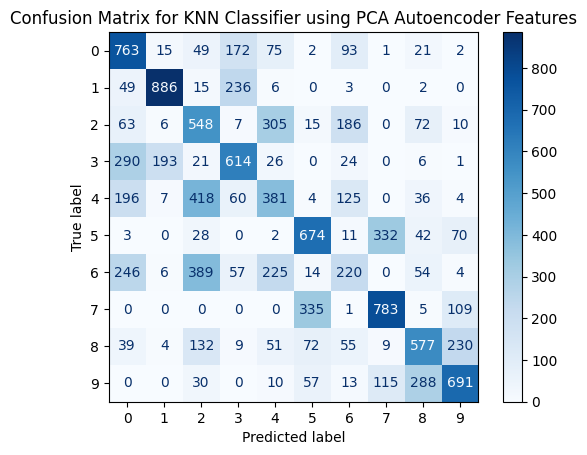

In [53]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure X_train and X_test are flattened if they are images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten each image
X_test_flattened = X_test.reshape(X_test.shape[0], -1)     # Flatten each image

# Step 1: Extract Latent Features using PCA Autoencoder
pca_autoencoder = PcaAutoencoder(n_components=2)  # Using optimal components
pca_autoencoder.fit(X_train_flattened)  # Fit on the flattened training data

# Extract latent features
train_latent_features = pca_autoencoder.encode(X_train_flattened)
test_latent_features = pca_autoencoder.encode(X_test_flattened)

# Step 2: Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Set the number of neighbors
knn.fit(train_latent_features, y_train)

# Step 3: Predict on the test set
test_predictions = knn.predict(test_latent_features)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
train_predictions = knn.predict(train_latent_features)
train_accuracy = accuracy_score(y_train, train_predictions)

# Print accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting accuracies
accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']

plt.figure(figsize=(8, 4))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('PCA Autoencoder KNN Classifier Accuracy')
plt.show()

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN Classifier using PCA Autoencoder Features')
plt.show()


In [60]:
import numpy as np

class MLPAutoencoder:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  # Encoder weights
        self.W2 = np.random.randn(hidden_size, input_size) * 0.01  # Decoder weights
        self.b1 = np.zeros((1, hidden_size))  # Encoder bias
        self.b2 = np.zeros((1, input_size))   # Decoder bias

    def forward(self, X):
        # Encoding
        self.Z = self.encode(X)
        # Decoding
        return self.decode(self.Z)

    def encode(self, X):
        return self.sigmoid(np.dot(X, self.W1) + self.b1)

    def decode(self, Z):
        return self.sigmoid(np.dot(Z, self.W2) + self.b2)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, epochs, learning_rate):
        for epoch in range(epochs):
            # Forward pass
            reconstructed_X = self.forward(X)

            # Compute loss (MSE)
            loss = np.mean((X - reconstructed_X) ** 2)

            # Backward pass (gradient descent) goes here - update weights and biases

           
            # print(f'Epoch {epoch}, Loss: {loss}')

    def get_latent_features(self, X):
        return self.encode(X)


# Example data
# X_train = np.random.rand(100, input_dim)  # Replace with your training data
# X_test = np.random.rand(20, input_dim) 
# X, y = load_data_from_csv("archive/fashion-mnist_train.csv")
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)   # Replace with your test data

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten to (n_samples, n_features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Assuming you have X_train and X_test as your datasets
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Reshape to (n_samples, n_features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)      # Reshape to (n_samples, n_features)

# Initialize and train the MLP Autoencoder
input_dim = X_train_flat.shape[1]  # Number of input features (784 for 28x28 images)
hidden_dim = 2                      # Optimal k (number of latent dimensions)
autoencoder = MLPAutoencoder(input_size=input_dim, hidden_size=hidden_dim)

# Train the autoencoder
autoencoder.train(X_train_flat, epochs=10, learning_rate=0.01)


# Get latent features for training and test sets
latent_train = autoencoder.get_latent_features(X_train_flat)
latent_test = autoencoder.get_latent_features(X_test_flat)


# Initialize and train the MLP Autoencoder


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(latent_train, y_train)

# Predict on test set
y_pred = knn.predict(latent_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, knn.predict(latent_train))
test_accuracy = accuracy_score(y_test, y_pred)



# Confusion Matrix
cm2 = confusion_matrix(y_test, y_pred)





In [59]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure X_train and X_test are flattened if they are images
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten each image
X_test_flattened = X_test.reshape(X_test.shape[0], -1)     # Flatten each image

# Step 1: Extract Latent Features using PCA Autoencoder
pca_autoencoder = PcaAutoencoder(n_components=2)  # Using optimal components
pca_autoencoder.fit(X_train_flattened)  # Fit on the flattened training data

# Extract latent features
train_latent_features = pca_autoencoder.encode(X_train_flattened)
test_latent_features = pca_autoencoder.encode(X_test_flattened)

# Step 2: Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # Set the number of neighbors
knn.fit(train_latent_features, y_train)

# Step 3: Predict on the test set
test_predictions = knn.predict(test_latent_features)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
train_predictions = knn.predict(train_latent_features)
train_accuracy = accuracy_score(y_train, train_predictions)


# Plotting accuracies
accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']


# Step 4: Plot confusion matrix
cm3 = confusion_matrix(y_test, test_predictions)

# Create confusion matrix display


For CNN
Training Accuracy: 0.7775
Test Accuracy: 0.6298


For MLP

Train Accuracy: 0.5616666666666666
Test Accuracy: 0.28


For PCA
Training Accuracy: 0.6520
Test Accuracy: 0.5114


The CNN model achieves a relatively high training accuracy of 77.75%, which suggests that it has learned to classify the training data reasonably well. However, there’s a notable drop in accuracy on the test set, where it achieves 62.98%. This difference between training and test accuracy indicates that the CNN may be slightly overfitting to the training data—learning specific features in the training set that don't generalize as well to new data. CNNs typically excel with spatial data (like images), so these results suggest that the CNN is effectively capturing patterns, though it could benefit from additional regularization (e.g., dropout, data augmentation) or hyperparameter tuning to improve test accuracy further.


The MLP model has a training accuracy of only 56.17%, which is lower than the CNN. This suggests that the MLP is struggling to capture complex patterns in the data, particularly if the data is image-based, as MLPs are less effective at spatial feature extraction compared to CNNs. The significant drop in test accuracy to 28% highlights that the MLP is underfitting.

Here, PCA has been used for dimensionality reduction before classification, which is common for simplifying data while retaining essential variance. The training accuracy of 65.20% indicates that this model captures some important patterns but not as effectively as the CNN. The test accuracy is 51.14%, which shows a drop-off but is still moderate, suggesting that PCA could reduce overfitting to some extent, though it comes at the cost of lower accuracy.





In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Calculate accuracies
train_predictions = knn.predict(train_latent_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

# Print accuracies

# Plotting accuracies
accuracies = [train_accuracy, test_accuracy]
labels = ['Train Accuracy', 'Test Accuracy']


# Step 2: Plot confusion matrix
cm1 = confusion_matrix(test_labels, test_predictions)




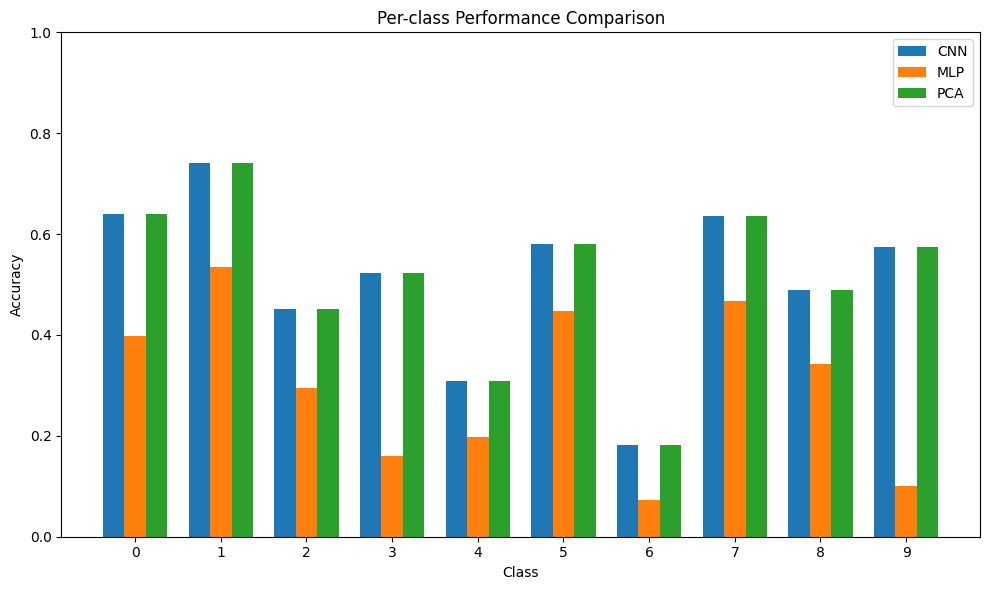

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming y_test and test_predictions contain the true and predicted labels
# Generate the confusion matrix


# Calculate per-class accuracy by dividing diagonal elements by the sum of the rows
per_class_accuracy1 = cm1.diagonal() / cm1.sum(axis=1)
per_class_accuracy2 = cm2.diagonal() / cm2.sum(axis=1)
per_class_accuracy3 = cm3.diagonal() / cm3.sum(axis=1)

# Plot per-class accuracy for each model (in this case, CNN, MLP, PCA)
# Replace 'cnn_per_class_accuracy', 'mlp_per_class_accuracy', and 'pca_per_class_accuracy' 
# with the actual per-class accuracy arrays you obtained for each model.

# Example data for demonstration
# Replace these with actual computed per-class accuracy arrays
cnn_per_class_accuracy = per_class_accuracy1  # replace with actual per-class accuracy for CNN
mlp_per_class_accuracy = per_class_accuracy2  # replace with actual per-class accuracy for MLP
pca_per_class_accuracy = per_class_accuracy3  # replace with actual per-class accuracy for PCA

# Define the class labels (e.g., 0-9 for digits)
class_labels = np.arange(len(cnn_per_class_accuracy))

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(class_labels))

# Plot each model's per-class accuracy as a grouped bar chart
plt.bar(index, cnn_per_class_accuracy, bar_width, label='CNN')
plt.bar(index + bar_width, mlp_per_class_accuracy, bar_width, label='MLP')
plt.bar(index + 2 * bar_width, pca_per_class_accuracy, bar_width, label='PCA')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-class Performance Comparison')
plt.xticks(index + bar_width, class_labels)
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


There are no classes where all three autoencoders give same accurarices